In [11]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/nfh/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'ticks']


Files:
 ['phb1v1_c004.dat', 'phb1v1_c005.dat', 'phb1v1_c006.dat', 'phb1v1_c008.dat', 'phb1v1_c010.dat', 'phb1v1_c015.dat', 'phb1v1_c020.dat', 'phb1v1_c030.dat', 'phb1v1_c040.dat', 'phb1v1_c050.dat']
thresh
[89.18248808893594, 85.04613470765949, 76.83683383365705, 69.40003291880029, 63.3715689945703, 51.69838440111421, 45.02855966413693, 38.739408489909536, 35.13551565642058, 32.505201429946375]


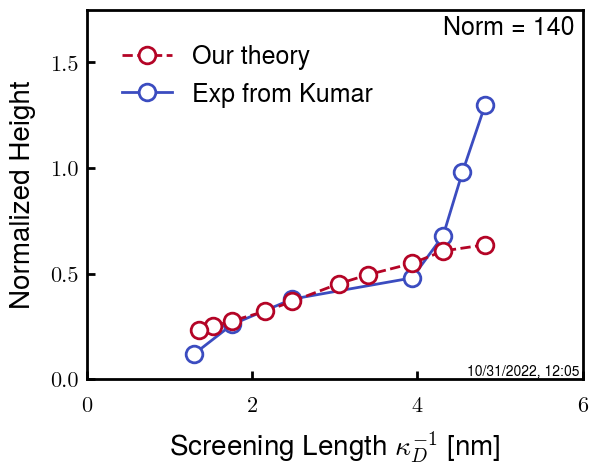

maxpt
[19.344120209083055, 17.054654025838616, 7.875510474628671, 7.144554406470197, 6.751489962546206, 6.233660091281744, 5.967571097943621, 5.66134737259021, 5.492769213335778, 5.384790655214987]


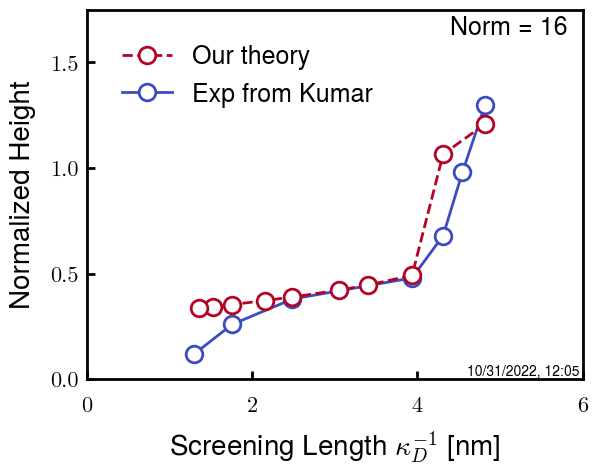

norm
[46.807554079612096, 44.593146288416875, 33.655795782453346, 28.934116686171024, 25.679273987572543, 20.963634954279566, 18.556289024093328, 15.622580671689178, 13.642387325183893, 12.144802325295787]


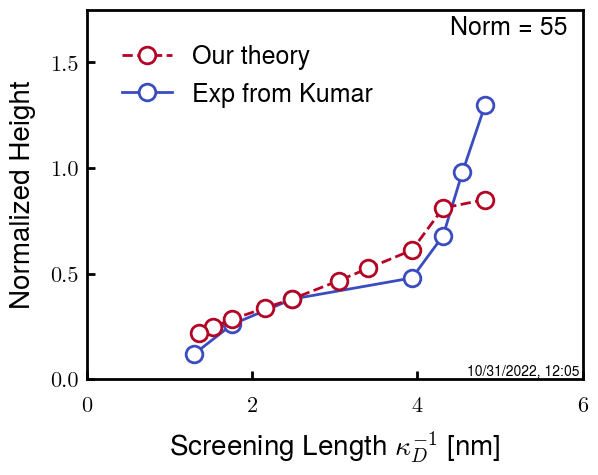

In [3]:
## NFH
from datetime import datetime
labs =  ['004', '005', '006', '008', '010', '015', '020', '030', '040', '050']
tack = [0]*len(labs) #see add for options
#tack[8:9] = [1]*2
#tack[10:] = [2]*6
add = ['', '_1C', '_']
read_list = ['phb1v1_c'+add[tack[ind]]+i+'.dat' for ind, i in enumerate(labs)]
print("Files:\n", read_list)
read_list = [GIT+i for i in read_list]
algs = ['thresh', 'maxpt', 'norm']

##########################################
##########################################
b0 = 1.0 
norms = [140, 16, 55]
thresh = 1e-04
##########################################
##########################################

for algind in range(3):
    print(algs[algind])
    LH = np.zeros(len(read_list))
    print("[", end="")
    for i in range(len(read_list)): 
      LH[i] = tjy.H_find(read_list[i], alg=algs[algind], b0=b0, thresh=thresh)
      print(LH[i], end="")
      if i!=(len(read_list)-1): print(", ", end="")
    print("]")

    ####################


    SrCs = [float(i) for i in labs]
    Sr_equil = LH
    Sr_equil = np.divide(Sr_equil,  norms[algind])
    CsDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in SrCs]

    #Sr2014 pH2.4 fitted in Illustrator
    x = [4, 4.5, 5, 6, 15, 30, 55]
    y = [1.3, 0.98, 0.68, 0.48, 0.38, 0.26, 0.12]
    xDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in x]

    f, ax = plt.subplots(1,1)

    ax.plot(CsDeb, Sr_equil, 'o--', color=warm_red, mew=2, ms=12, markerfacecolor='w', zorder=3, label="Our theory")
    ax.plot(xDeb, y, 'o-', color=cool_blue, mew=2, ms=12, markerfacecolor='w',label="Exp from Kumar")

    plt.gca().text(0.85, 0.95, 'Norm = {:.0f}'.format(norms[algind]), transform=plt.gca().transAxes, fontsize=18,
           ha='center', va='center', bbox=dict(boxstyle='square', facecolor='none', edgecolor='none'))
    plt.gca().text(0.88, 0.02, '{}'.format(datetime.now().strftime("%m/%d/%Y, %H:%M")), transform=plt.gca().transAxes, fontsize=10,
           ha='center', va='center', bbox=dict(boxstyle='square', facecolor='none', edgecolor='none'))
    ax.set_title(r"")
    ax.set_ylim(0, 1.75) #0.5
    plt.yticks([0.0, 0.5, 1.0, 1.5])
    plt.xticks([0, 2, 4, 6, 8])
    ax.set_xlim(0,6) #2

    ax.set_xlabel(r'Screening Length $\mathbf{\kappa}_D^{-1}$'+' [nm]')
    ax.set_ylabel('Normalized Height')

    leg = ax.legend(loc = 2,frameon=False,fontsize=18)

    tjy.ticks()
    plt.show()



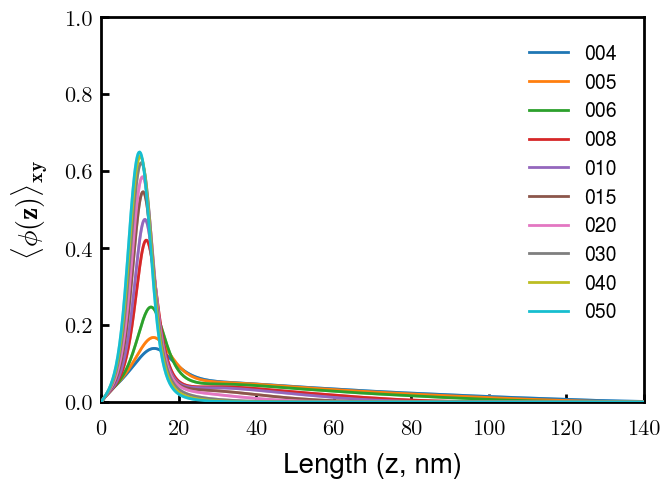

(<Figure size 700x500 with 1 Axes>,
 <AxesSubplot: xlabel='Length (z, nm)', ylabel='$\\bf{\\langle\\phi(z)\\rangle}_{xy}$'>)

In [11]:
labs = ['004', '005', '006', '008', '010', '015', '020', '030', '040', '050']
read_list = [GIT+"phb2v20_c"+i+".dat" for i in labs]
# read_list = [GIT+"ph_a021c"+i+"_x103s002.dat" for i in labs]
# labs = ['001', '002', '003', '005', '010', '025', '050', '100']
# read_list = [GIT+"phb10v10L_c"+i+".dat" for i in labs]

tjy.plot_pha(read_list, b0=2.0, x1_end=140, x2_end=150, y2_end=0.02, labs=labs, double=False)

(0.000707945784384138, 1.4125375446227544)


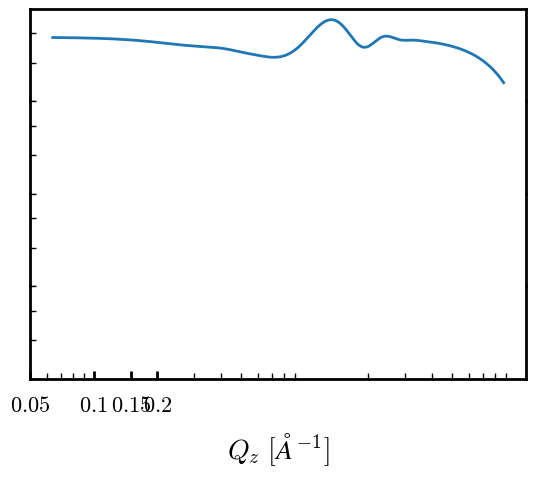

In [28]:
rho_e_w = 3.33e23 # electron density of water, e/cm3 (Source: Brasla, 1985)
rho_e_w *= 1e2**3 / 1e10**3 # e/AA3
r_e = 2.818e-15 # m
r_e *= 1e10 # AA

def RQZ_pha(phname, qz):
    ph = pd.read_csv(phname, sep="\s+", skiprows=0, header=None)
    pha = ph[2]
    pha.update(pd.Series([2.32], index=[0])) # electron density of SiO2 substrate, assuming polymer electron density 1.0: (CH2)x = 0.95 (Source: Russel, 1990)
    phb = ph[10]
    phe = pha*1.0 + phb*rho_e_w # electron density profile, rho_e_protein = 1.0
    z = ph[0]*10 # nm to AA
    dz = z[1] - z[0]
    dpdz = np.gradient(phe, dz)
    return [RQZ(z, dpdz, i) for i in qz]

def RQZ(z, dpdz, qzi): return np.power(np.absolute(np.trapz(dpdz*np.exp(1j*qzi*z), x=z)/rho_e_w), 2) # j is imaginary

def Z_PHA(phname):
    ph = pd.read_csv(phname, sep="\s+", skiprows=0, header=None)
    ph.iloc[0,1] = 10 # Artificial substrate with 5x electron density as polymer and solvent
    return ph.iloc[:,0:2] 

def RQZ_plot3(row, qz, filename, light_frac):
  laxs[row].plot(qz, RQZ_pha(filename, qz), color='C0', alpha=1.0)
  return

qz = np.logspace(-3,0,1000) # 0.001 to 1

light_arr = np.linspace(1.0,1.0, 1)
f, laxs = plt.subplots(4,1)
RQZ_plot3(0, qz, GIT+'phb2v20_c006.dat', light_arr[0])


for i in laxs:
  i.set_xscale('log')
  # i.set_xlim([0.05, 0.20])
  ticklabs = [0.05, 0.10, 0.15, 0.20]
  i.set_xticks(ticklabs)
  i.set_xticklabels(['${}$'.format(i) for i in ticklabs])
  i.set_xticklabels([], minor=True)
  i.set_yscale('log')
  i.set_ylim([30, 60])
  i.tick_params(axis='y',which='both', labelleft=False)
  if i != laxs[-1]: 
    i.tick_params(axis='x', which='both', length=0.0)
    i.tick_params(axis='x', which='both', labelbottom=False)
    i.spines['bottom'].set_color('none')
  if i!= laxs[0]: 
    i.spines['top'].set_color('none')

print(laxs[0].get_xlim())
    
plt.subplots_adjust(hspace=0)
laxs[-1].set_xlabel(r'$Q_z$' ' ' r'$[\AA^{-1}]$')
plt.show()

In [64]:
labs =  ['004', '005', '006', '008', '010', '015', '020', '030', '040', '050']
tack = [0]*len(labs) #see add for options
#tack[8:9] = [1]*2
#tack[10:] = [2]*6
add = ['', '_1C', '_']
read_list = ['phb204_c'+add[tack[ind]]+i+'.dat' for ind, i in enumerate(labs)]
print("Files:\n", read_list)
read_list = [GIT+i for i in read_list]

b0 = 2.0 ########################################################

print("[", end="")
for i in range(len(read_list)): 
  print(Gibbsf(read_list[i], b0), end="")
  if i!=(len(read_list)-1): print(", ", end="")
print("]")

Files:
 ['phb204_c004.dat', 'phb204_c005.dat', 'phb204_c006.dat', 'phb204_c008.dat', 'phb204_c010.dat', 'phb204_c015.dat', 'phb204_c020.dat', 'phb204_c030.dat', 'phb204_c040.dat', 'phb204_c050.dat']
[47.072316105215066, 43.80163822417714, 40.553781442826605, 33.74345145045215, 26.435680243045564, 20.04621971732655, 18.616687699146954, 17.685826677916314, 17.493512107544532, 17.10685582144304]


In [8]:
read_list = ['040', '050', '060', '070', '075', '080', '085', '090', '095', '100', '105', '110', '115', '120', '125',
              '130', '135', '140', '145', '150', '155', '160', '165', '170', '175', '180', '185', '190', '195', '200']
x = [float(i)/100 for i in read_list]
read_list = ['p1a0_x'+i+'.dat' for i in read_list]
H = [Gibbsf(i, 1.0) for i in read_list]

FileNotFoundError: [Errno 2] No such file or directory: 'p1a0_x040.dat'

In [9]:
plt.plot(x, H, 'o')

NameError: name 'H' is not defined

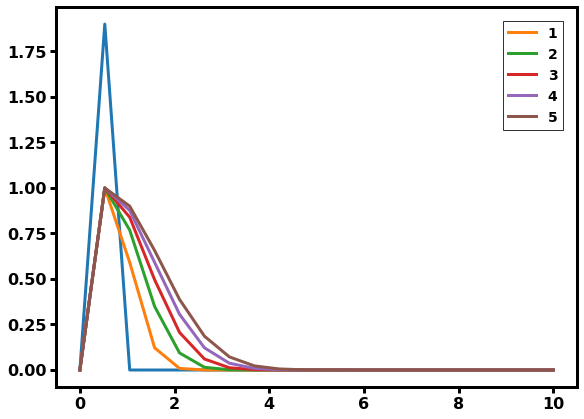

In [ ]:
plt.figure()
x = np.linspace(0,10,20)
dx = x[1]-x[0]
y = [0] + [1/dx]+[0]*(len(x)-2)
plt.plot(x, y)

for i in [1, 2, 3, 4, 5]:
  yg = np.exp(-(x-x[1])**2/(i*dx))
  yg[0] = 0    
  plt.plot(x, yg, label=i)
plt.legend()
plt.show()